Source publication for dataset: 
https://www.nature.com/articles/s41467-018-02866-0

In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import networkx as nx
import hypernetx as hnx

In [2]:
n_cells = 456
n_genes = 100
PWscores = np.zeros((n_cells, n_genes, n_genes))

for i in range(n_cells):
    path = "./../data/TEsmESC/geneXgene{i}.csv".format(i=(i+1))
    df_temp = pd.read_csv(path)
    PWscores[i, :, :] = np.copy(df_temp.values)
    

# Visualizing TE scores across cells (over time)

In [3]:
# heat_fig = sn.heatmap(PWscores[0, :, :], square=True)
    # as_file = heat_fig.get_figure()
    # path = "./../out/cell{i}.png".format(i = i + 1)
    # as_file.savefig(path)
    # ax.tick_params(left=False, bottom=False)

# Creation of the hypergraph

Note: a simple canonical edge has the form of tail->head

In [4]:
"""
Merges tails with common heads to identify all the multi-arity relations to represent as hedges and updates the supplied incidence matrix with these final hedges.
_edges: a list of tuples (tail_set, head_set) of all the initial single-tailed edges (note: they are sets, not lists!)
B: a list of n_gene-sized integer numpy arrays to represent the incidence matrix to update.
"""
def merge_edges(_edges, B, W, cell_nw):
    
    # init
    edges = deepcopy(_edges)
    m = len(edges)

    # Stop when there's only a single edge left (not possible to merge anything else)
    while (m >= 2):
        
        new_edges = [] 
        for i in range(0, m, 1):
            e1 = edges[i]
            for j in range(i + 1, m, 1):
                e2 = edges[j]
                common_heads = e1[1].intersection(e2[1])
                if (len(common_heads) > 0):
                    
                    # The new edge
                    new_tails = e1[0].union(e2[0]) 
                    new_edge = ([new_tails, common_heads])
                    new_edges.append(new_edge)

                    # Updating old edges (their head sets)
                    e1[1] = set(e1[1] - common_heads)
                    e2[1] = set(e2[1] - common_heads)

        
        # TODO: weight the edges?
        # Add all edges with non-null head sets to the incidence matrix
        for edge in edges:
            if len(edge[1]) > 0:
                col = np.zeros(n_genes)
                w = 0
                for tail in edge[0]:
                    col[tail] = -1 #TODO: TESTING
                    for head in edge[1]:
                        w += cell_nw[tail, head]
                
                for head in edge[1]:
                    col[head] = 1
                
                B.append(np.copy(col))
                # add edge weight to edge matrix
                W.append(w)
        
        edges = deepcopy(new_edges)
        m = len(edges)

In [5]:
""" 
Creates a hypergraph, represented using an incidence matrix, from the given cell's PW gene network. 
cell_index: the index into the PWscores array for the desired cell.
p: percentage parameter to use in tolerance calculation; decides which relationships relative to the maximum PW TE. 
returns: B the incidence matrix of the constructed hypergraph. 
"""
def construct_hyper_graph(cell_index, p):
    # init
    unique_genes = set()
    cell_nw = PWscores[cell_index, :, :]

    # The incidence matrix (TODO: might use different data structures for B and W?)
    B = []

    # The weight matrix
    W = []

    # all scores within whatever % of the max
    tolerance = np.max(cell_nw) * p

    tails = set(np.arange(start=0, stop=n_genes, step=1))

    # debug var
    count = 0

    while (len(tails) > 0):
        edges = []
        new_tails = set()
        heads_to_remember = set()

        for tail in tails:
            heads = set(np.flatnonzero(cell_nw[tail, :] > tolerance))
            
            # Termination condition: once there's no new heads added this never gets hit, no new tails get added and the tail set becomes null at the end of while itr
            if (len(heads) > 0) and (heads.isdisjoint(unique_genes)):
                
                count += 1
                
                for head in heads:
                    # error handling
                    if (cell_nw[tail, head] <= tolerance):
                        raise ValueError("Improper pair discovered.")

                    # update the next-level tails
                    new_tails.add(head)
                    
                    # TODO: maybe make the set of all heads for this level here and wait till the end of the iteration to deep copy it over?
                    heads_to_remember.add(head)
                    
                # update the edge set for this hgraph level
                tail_as_set = set()
                tail_as_set.add(tail)
                edges.append([tail_as_set, heads])
        
        for h in heads_to_remember:
            unique_genes.add(h)

        merge_edges(edges, B, W, cell_nw)
        tails = set(deepcopy(new_tails))
    
    return B, W



In [8]:
hedges = []
weights = []
# TODO: Test proper via some contrived examples
for i in range(n_cells):
    G, W = construct_hyper_graph(i, 0.8)
    if (len(G) > 0):
        hedges.append(np.transpose(np.array(G)))
        weights.append(np.array(W))


In [10]:
H = np.concatenate(hedges, axis=1)
W = np.concatenate(weights)
H.shape

(100, 1054)

In [23]:
# # pruning TFs 
# count = 0
# to_prune = []
# gene_labels = df_temp.columns.to_numpy()

# for v in range(n_genes):
#     deg_v = np.sum(H[v,:])
#     if deg_v == 0:
#         # remove the vertex, since it isn't involved in any hedges, therefore won't be in any pathways
#         count += 1
#         to_prune.append(v)

# n_genes = n_genes - count

In [24]:

# pruned_labels = np.delete(gene_labels, to_prune)
# pruned_H = np.delete(H, to_prune, axis=0) # delete rows with indices in to_prune

# # Checking it did its job
# if np.intersect1d(pruned_labels, gene_labels[to_prune]).shape[0] != 0:
#     raise ValueError("Pruning of background genes failed.")

# hedges[0]

# Hypergraph Visualization
Lookin' like there's a bug in the construction of the graph! debug time!

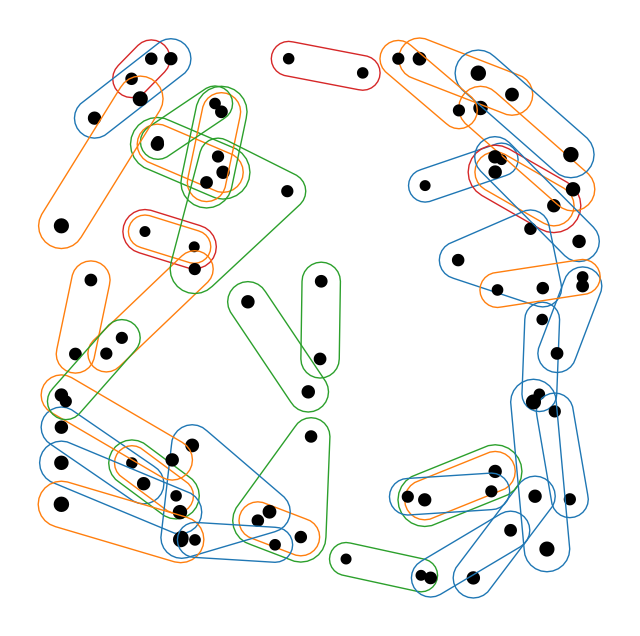

In [28]:
for i in range(len(hedges)):
    hnx.draw(hnx.classes.Hypergraph.from_numpy_array(hedges[i]), with_node_labels=False, with_edge_labels=False)
    # hnx.draw(hnx.classes.Hypergraph.from_numpy_array(hedges[i]))

In [ ]:
# hnx.draw(HG)
# hnx.drawing.rubber_band.draw(HG, with_node_labels=False, with_edge_labels=False) Full graph is completely incomprehensible

# Forming the graph Laplacian

In [ ]:
# Creating the Diagonal vertex and edge degree matrix  
Dv = np.zeros((n_genes, n_genes))
De = np.zeros((pruned_H.shape[1], pruned_H.shape[1]))


for v in range(n_genes):
    deg_v = np.sum(pruned_H[v,:])
    if deg_v == 0:
        raise ValueError("Pruning of background genes failed.")
    else:
        Dv[v, v] = deg_v

for e in range(pruned_H.shape[1]):
    De[e, e] = np.sum(pruned_H[:, e])


# Normalized Laplacian of the hypergraph 
Dvis = np.linalg.inv(np.sqrt(Dv)) # replace each diagonal entry with the reciprocal of its square root, i.e. di with 1/sqrt(di)
L_n = (Dvis @ pruned_H @ np.linalg.inv(De) @ (pruned_H.T) @ Dvis) # TODO: add W matrix later


In [ ]:
eigvals, eigvecs = np.linalg.eig(L_n) # looks really good!

# # Checking evectors and evalues
# eigvals[np.where(eigvals < 0.5)[0]]
# eigvals[eigvals < 0.3]
# eigvecs[55]
# np.sum(eigvals < 0)
# np.argmin(eigvals)
# eigvecs[:,0] are the eigenvecs the rows or columns of this matrix? They're the columns
# np.sum(L_normal * eigvecs[:,0]) # that's pree much 0


# From *On Spectral Clustering: Analysis and an algorithm*

From L-normal:
1. Find k **largest** orthogonal eigen*vectors* (orthogonal to avoid vecs of repeated eigen*values*) of L
2. Make a matrix of 'em, n_genes x k = X
3. Y = Normalize each row of X to have unit length
4. Treat each row of Y as a point in R<sup>k</sup>, cluster into k-clusters via kmeans
5. Assign rows i (you can just use the gene labels vector) to cluster j iff row i in Y was assigned to cluster j 



In [ ]:
# sort eigenvals, then sort eigenvecs by the eigenvals
sorted_indices = np.flip(np.argsort(eigvals))
sorted_eigvals = eigvals[sorted_indices] # sort the vals
sorted_eigvecs = eigvecs[:,sorted_indices] # sorts the columns

In [ ]:
# Sanity check to ensure eigenvecs got sorted
tolerance = 0.0001
min_index = np.argmin(eigvals)
np.sum(np.abs(np.abs(eigvecs[:,min_index]) - np.abs(sorted_eigvecs[:,n_genes - 1])) < tolerance) == n_genes

# Visualizing Eigenvalues for Hyperparameter Selection

In [ ]:
# y = np.flip(eigvals)
x = np.arange(n_genes)
plt.scatter(x, sorted_eigvals)

# Perform the clustering to determine the pathways

In [ ]:
# From the figure, everything above 0.6, manually count 6 dots above 0.6 and that's the eigengap!
k = 6
skip = 0 # Ng et al don't skip anything
kmeans = KMeans(n_clusters=k)
Y = sorted_eigvecs[:, skip:(k + skip)]
kmeans.fit(Y)
labels = kmeans.labels_
np.unique(kmeans.labels_, return_counts=True) # clusters and the number of genes assigned to each cluster


In [ ]:
clusters = []
for i in range(k):
    genes = np.argwhere(kmeans.labels_ == i).flatten()
    clusters.append(pruned_labels[genes])

In [ ]:
# TODO: analyze what's in the clusters proper
clusters[0]